In [0]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [0]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets


In [0]:
# Mounts Google drive to runtime instance, basically makes it so you can access 
# drive files
from google.colab import drive
#drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Issues with directories, use this to reset cwd and then move into desired directory 
#os.chdir("/content")
startingDir = os.getcwd()
print(startingDir)

/content


In [11]:
""" Code to get max and min temperature values from dataset """
# Ensure Directories are all correct
os.chdir(startingDir)
os.getcwd()
os.chdir("drive/My Drive/BCIMLR/csvdata")

# Set starting min and maxes
absolute_min = 2000
absolute_max = -10

# Iterate through csvs to find the real max and mins
list_files = os.listdir()

# counter = 0
# print(len(list_files))
# for fileName in list_files:
#   if fileName.endswith("t.csv"):
#     if counter % 10 == 0:
#       print(fileName, "----", counter)
#     counter += 1    
#     my_data = pd.read_csv(fileName)
#     max_val = my_data.to_numpy().max()
#     min_val = my_data.to_numpy().min()
#     if max_val > absolute_max:
#       absolute_max = max_val
#     if min_val < absolute_min:
#       absolute_min = min_val
# print(absolute_max)
# print(absolute_min)

995
2015_03_14_14_10_bci_t.csv ---- 0
2015_03_14_13_50_bci_t.csv ---- 10
2015_03_14_14_45_bci_t.csv ---- 20
2015_03_14_16_05_bci_t.csv ---- 30
2015_03_14_16_40_bci_t.csv ---- 40
2015_03_14_17_30_bci_t.csv ---- 50
2015_03_14_19_05_bci_t.csv ---- 60
2015_03_14_20_00_bci_t.csv ---- 70
2015_03_14_19_40_bci_t.csv ---- 80
2015_03_14_21_05_bci_t.csv ---- 90
2015_03_14_22_00_bci_t.csv ---- 100
2015_03_14_22_35_bci_t.csv ---- 110
2015_03_14_23_30_bci_t.csv ---- 120
2015_03_15_00_20_bci_t.csv ---- 130
2015_03_15_01_10_bci_t.csv ---- 140
2015_03_15_01_55_bci_t.csv ---- 150
2015_03_15_02_50_bci_t.csv ---- 160
2015_03_15_03_50_bci_t.csv ---- 170
2015_03_15_04_55_bci_t.csv ---- 180
2015_03_15_05_10_bci_t.csv ---- 190
2015_03_15_06_10_bci_t.csv ---- 200
2015_03_15_07_15_bci_t.csv ---- 210
2015_03_15_07_25_bci_t.csv ---- 220
2015_03_15_08_20_bci_t.csv ---- 230
2015_03_15_09_30_bci_t.csv ---- 240
2015_03_15_10_15_bci_t.csv ---- 250
2015_03_15_11_40_bci_t.csv ---- 260
2015_03_15_12_05_bci_t.csv ---- 270

In [0]:
""" Data from ~950 csvs """
ABS_MAX = 38.0682135918655
ABS_MIN = 22.929104487687802

In [0]:
""" CREATE CUSTOM DATASET """
# Pulls from pool of 900 thermal images
class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])
        
        #tempGPP_arr = np.asarray(self.data_info.iloc[:,1])
        # CASTING GPP TO INT, to mimic "buckets" all 24.XXX values go into 24 bucket etc.
        #self.GPP_arr = self.GPP_arr.astype(np.int_)
        
        self.transform = transforms.ToTensor()#transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5))])
            
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Standardization of values from orignal csv file in order to properly
        # process image, first translates thermal values to 0-1 range, then 
        # multiply by 255 to enable processing by PIL Image library
        max_val = ABS_MAX 
        min_val = ABS_MIN 
        np_thermal_img = ((np_thermal_img-min_val)/(max_val - min_val)) * 255
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Creation of image, conversion to grayscale
        thermal_img = Image.fromarray(np_thermal_img)
        thermal_img = thermal_img.convert('L')
        # Transform image to tensor
        tensor_thermal_img = self.to_tensor(thermal_img)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        # Apply transform to image if present
        #if self.transform:
            #tensor_thermal_img = self.transform(tensor_thermal_img)
        #sample = {'image': tensor_thermal_img, 'GPPVal': single_image_GPP}
        #return sample
        #Return thermal image as tensor and GPP label
        return(tensor_thermal_img, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [0]:
""" LOAD IN DATA """
os.chdir(startingDir)
# Number of subprocesses to use for data loading 
# Note: Currently unused but can be altered in future
num_workers = 0
# How many samples per batch to load
batch_size = 3
# Proportion of training set to use for validation and testing
# Note: this will be split in equal halves, one for validation, one for testing
valid_and_test_proportion = 0.3


# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])
# Define custom datasets, for training and for testing
# Note: Will be using 10,000 data for testing, 50,000 data for training in future
masterfileMLLocation = r"drive/My Drive/BCIMLR/csvdata/populatedGPPs.csv"
BCIDataset = BCIDataset2(masterfileMLLocation)

# Obtain indices for training, validation and testing datasets
num_train = len(BCIDataset)         # Number of data points (csv files to be used)
indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
np.random.shuffle(indices1)         # Shuffled indices
# Splitting training from validation/testing
split1 = int(np.floor(valid_and_test_proportion * num_train))

train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
# Splitting validation/testing up into their individual groups
num_valid_test = len(valid_and_test_indices)

split2 = int(np.floor(0.5 * num_valid_test))
valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]
# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Prepare data loaders 
train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers)

tensor(12.4104, dtype=torch.float64)
tensor(12)
(1, 320, 240)
tensor(13.7160, dtype=torch.float64)
tensor(13)
(1, 320, 240)
tensor(17.9746, dtype=torch.float64)
tensor(17)
(1, 320, 240)


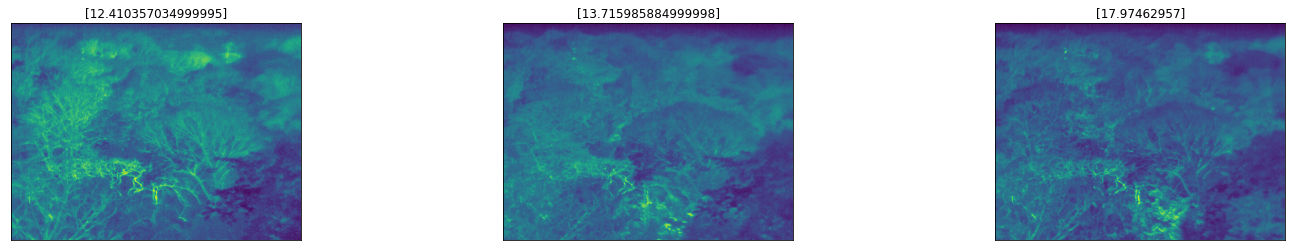

In [20]:
""" VISUALIZE A BATCH OF THE DATA 
    Taken straight from dataloader """
os.chdir(startingDir)
csvfilesMLLocation = r"drive/My Drive/BCIMLR/csvdata"
os.chdir(csvfilesMLLocation)

import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.rot90(np.squeeze(img)))
    
# Obtain one batch of training images
dataiter = iter(train_loader)
type(dataiter)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

    # print(images[1].shape)
    # imgtoshow = Image.fromarray(images[1], 'L')
    # imgtoshow.show()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 3 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    print(labels[idx])
    print(labels[idx].long())
    ax.set_title([labels[idx].item()])
    # Save Images for inspection
    print(images[idx].shape)
os.chdir(startingDir)

In [0]:
"""Abbreviated network, to allow for easy transisiton to regression"""
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # Convulutional Layer 2 (sees 160 x 120 x 16 tensor, reduced height and width from max pooling layer)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear and Batchnorm Layers
        self.fc1 = nn.Linear(32 * 80 * 60, 100)
        self.BatchN = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 80 * 60)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add last layer
        x = (self.fc2(x))
        return x

In [29]:
# Defining the model
model = BCIModel()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr =0.001) 
# defining loss function
criterion = nn.MSELoss()
print(model)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=153600, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...


In [30]:
""" TRAINING OF MODEL """
os.chdir(startingDir)
csvfilesMLLocation = r"drive/My Drive/BCIMLR/csvdata"
os.chdir(csvfilesMLLocation)
# Number of epochs to train the model
# try 10, 100, 500, 1000
n_epochs = 5

valid_loss_min = np.Inf    # Track change in validation loss, set 

for epoch in range(1, n_epochs+1):
    print("Epoch #:", epoch)
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # Clear the gradients fo all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # Calculate avearage losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_BCI.pt')
        valid_loss_min = valid_loss
        
print("Operation Complete")

Epoch #: 1
Epoch: 1 	Training Loss: 44.009262 	Validation Loss: 27.831138
Validation loss decreased (inf --> 27.831138).  Saving model ...
Epoch #: 2
Epoch: 2 	Training Loss: 35.458965 	Validation Loss: 47.735372
Epoch #: 3
Epoch: 3 	Training Loss: 32.777880 	Validation Loss: 37.124406
Epoch #: 4
Epoch: 4 	Training Loss: 30.397894 	Validation Loss: 26.257255
Validation loss decreased (27.831138 --> 26.257255).  Saving model ...
Epoch #: 5
Epoch: 5 	Training Loss: 27.062042 	Validation Loss: 23.313488
Validation loss decreased (26.257255 --> 23.313488).  Saving model ...
Operation Complete


In [31]:
""" TESTING OF MODEL """

# Track test loss
test_loss = 0.0
num_predictions = len(test_indices)

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model.eval()

counter = 0
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update test loss 
        test_loss += loss.item()*data.size(0)
        
        # Example data tensors
        if counter < 5:
          print("Output of network:\t", output)
          print("Target Values:\t\t", target,"\n")
          counter += 1
        


    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss (mean sqaured error): {:.6f}\n'.format(test_loss))

Output of network:	 tensor([1.1552, 2.1341, 4.5630], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 22.2394], device='cuda:0') 

Output of network:	 tensor([20.0361, 24.6259,  2.3410], device='cuda:0')
Target Values:		 tensor([16.3137, 17.6588,  0.0000], device='cuda:0') 

Output of network:	 tensor([ 2.0314,  1.1792, 19.3569], device='cuda:0')
Target Values:		 tensor([ 2.7426,  0.0000, 13.8731], device='cuda:0') 

Output of network:	 tensor([13.3230, 10.6760,  2.5085], device='cuda:0')
Target Values:		 tensor([9.3679, 5.9028, 0.0000], device='cuda:0') 

Output of network:	 tensor([ 3.9109, 22.7903, 24.9110], device='cuda:0')
Target Values:		 tensor([ 0.0000, 17.0326, 19.1491], device='cuda:0') 

Test Loss (mean sqaured error): 4.131700

